# Inverse Reinforcement Learning with Grid World Traversal

<!-- This notebook dives into the concept of **Inverse Reinforcement Learning (IRL)**, its basics, background and a simple example using grid world  -->

## Problem Definition

The idea of reinforcement learning (RL) is to have an agent traversing through an environment, making decisions to accumulate rewards obtained for reaching each state and maximizing these rewards to acquire an optimal solution across the whole environment. To implement an RL model, one has to have information about the reward function (rewards to be given for reaching states), policies, model of the environment, value function for the environment and background data. But what if this data is unavailable? 

The only thing we have are **demonstrations** showing how the problem was solved. 

We can use **Inverse Reinforcement learning (IRL)**. The concept here is ***" learning by observing"***. The idea here is to infer the optimal policy by modelling the value function and reward behaviour from the given demonstrations of the expert without having to discover the environment explicitly. Simply put, IRL is an approach by which we can define the policy of decision-making and its respective rewards for choosing certain actions based on the observations shown by the experts. It is the exact opposite of the RL problem. IRL is also called apprentice learning. 

*Example: Engineering the self-driving car using traditional RL methods would require the creation of an extensive list of do's and don'ts with multiple instances of dilemmas in emergencies while also consuming tremendous computing power and tediously long durations. However, using IRL we can model the behaviour of the self-driving agent to follow the policy of the human expert without explicit definition of do's and don'ts therefore maximizing the learning efficiency while minimising the computing time consumed.*

Yet, scenarios exist where multiple policies may be optimal with different reward functions. That is, even though we have the same observed behaviour there exist many different reward functions that the expert might be attempting to maximize. Some of these reward functions are not logical e.g.: When all policies are optimal for the reward function but have zeros everywhere. Yet, we want a reward function that captures meaningful information about the task and is able to differentiate clearly between desired and undesired policies. To solve this, Ng and Russell {cite}`Ng2000ICML` formulate inverse reinforcement learning as an optimization problem. We should choose a reward function for which the given expert policy is optimal and maximize the reward function respectively. 

In this chapter, we introduce the Grid World problem and aim to solve it using IRL. The Gird World initializes a grid of $N$ states with $(N*N)$ dimensions. The goal is to traverse from $Start$ state to $End$ State based on the expert's demonstrations while inferring the optimal policy from the demonstrations.

<!-- ```{figure} Images/Initial_Grid_World.png
---
width: 400px
name: Initial_Grid_World
---
Initial Grid World
``` -->
```{image} Images/Initial_Grid_World.png
:width: 400px
:name: Initial_Grid_World
```
<!-- ![IRL_Grid](Images/Initial_Grid_World.png) -->

Within this practical task, we will implement two types of IRL algorithms reflecting the behaviour and inference of reward function & optimal policies (i.e. Linear Programming IRL and Maximum Entropy IRL {cite}`Ziebart2008AAAI`). 

<!-- ### References
1. [Ng, Andrew Y., and Stuart Russell, Algorithms for Inverse Reinforcement Learning, Icml. Vol. 1. No. 2. 2000](https://ai.stanford.edu/~ang/papers/icml00-irl.pdf)
2. [Brian D. Ziebart, Maximum Entropy Inverse Reinforcement Learning, AAAI. Vol. 8. 2008](https://cdn.aaai.org/AAAI/2008/AAAI08-227.pdf) -->

## Implementation

In this section, we introduce the problem in greater detail and initialise concepts, notations and code that will be used to define the Grid world and IRL problem. We begin with an overview of the problem with the following figure: 

![Gridworld_Full](Images/Run_Gridworld.png)

We have four demonstrations from experts on how to reach the end state and after IRL, we need to acquire the optimal of the above. Each one depicting an unique approach to reaching the goal state.

### Defining Markov Decision Processes (MDP)

**Markov Decision processes** is a method of solving sequential decision making problems in uncertainity sitautions. We use MDPs to model our grid world as an mathematical optimization problem. 

Given that we have expert trajecotries $E_T = \{\tau_1; \tau_2; ..... \tau_n; \}$  consitiuting of a set of state-action pair combinations. We define an MDP for our gird world enviroment as having

- $S = \{s_1, s_2, s_3,....s_n\}$ a finite set of all possible states that the agent can take $E_T$
- $A = \{a_1, a_2, a_3,....a_n\}$ a set of all possible actions an agent can take in $E_T$
- $T_{PA}(.)$ = state transition prbablity matrix mapping the probablities of moving from state $s$ to $s'$ upon taking action $a$ i.e. $T(s, a, s')$ extracted from $E_T$
- $\pi$ is the policy function that maps and defines the action to be takein in each state $(\pi: S -> A)$
- $\pi*$ is theoptimal policy that defines the optimal actionst o take in each sate $s$ such that the generated reward is maximium 
- $\tau$ = $\{(s_0, a_1, s_1); (s_1, a_2, s_2); (s_2, a_3, s_3);......(s_{n-1}, a_n, s_n);\}$ is a trajectory descrbing one complete iteration of the agent in the MDP. 
- $\gamma$ = The discount factor that gives relevance to future rewards. i.e. tendency to attract Long term or short term rewards.
- $R$ = The reward function mapping the state-action rewards i.e. the reward obatine for taking action $s$ and action $a$ to reach $s'$

As a whole, we define the MDP as a tuple of $(S, A, T_{PA}, \gamma)$ state, action and transition probablities. In our experiment we consider gamma to be 0.9.

### Intialization 

Now, we load libraries that we wil be using throughout this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from IPython.display import display
import ipywidgets as widgets

### Intializing Grid World Environment Code

This block of code creates an environment for grid world and produces sample trajectories of traverssing through the environment

In [2]:
class GridWorld:
    '''
    GridWorld class creates an env of grid world with 
    policies and trajectories of size N with dimension
    N*N. 
    '''
    
    def __init__(self, size):
        self.size = size
        self.n_states = size * size
        self.n_actions = 4
        self.transition_matrix = self._build_transitions()

    def _coord_to_state(self, x, y):
        return x * self.size + y

    def _state_to_coord(self, state):
        return divmod(state, self.size)

    def _build_transitions(self):
        T = np.zeros((self.n_states, self.n_actions, self.n_states))
        for s in range(self.n_states):
            x, y = self._state_to_coord(s)
            for a in range(self.n_actions):
                nx, ny = x, y
                if a == 0 and x > 0: nx -= 1
                if a == 1 and x < self.size - 1: nx += 1
                if a == 2 and y > 0: ny -= 1
                if a == 3 and y < self.size - 1: ny += 1
                ns = self._coord_to_state(nx, ny)
                T[s, a, ns] = 1
        return T

    # Generation of trajectory matrix
    def generate_policy_trajectory(self, start, goal):
        traj = [start]
        current = start
        while current != goal:
            x, y = self._state_to_coord(current)
            gx, gy = self._state_to_coord(goal)
            if gx > x: a = 1
            elif gx < x: a = 0
            elif gy > y: a = 3
            else: a = 2
            next_state = np.argmax(self.transition_matrix[current, a])
            traj.append(next_state)
            current = next_state
        return traj
    
    # Generation of Trajecotry matrix with additional random decisions 
    def generate_random_expert_trajectory(self, start, goal, noise_prob=0.2):
        traj = [start]
        current = start
        np.random.seed()
        while current != goal and len(traj) < self.n_states * 2:
            x, y = self._state_to_coord(current)
            gx, gy = self._state_to_coord(goal)
            preferred = []
            if gx > x: preferred.append(1)
            elif gx < x: preferred.append(0)
            if gy > y: preferred.append(3)
            elif gy < y: preferred.append(2)

            if not preferred:
                break

            # random move 
            if np.random.rand() < noise_prob:
                possible_actions = [a for a in range(4) if np.any(self.transition_matrix[current, a])]
                a = np.random.choice(possible_actions)
            else:
                a = np.random.choice(preferred)

            next_state = np.argmax(self.transition_matrix[current, a])
            if next_state == current:
                continue 
            traj.append(next_state)
            current = next_state
        return traj
    
# Feature Maxtrix creation
def build_feature_matrix(n_states):
    return np.eye(n_states)

# Feature expectations
def compute_feature_expectations(feature_matrix, trajectories):
    fe = np.zeros(feature_matrix.shape[1])
    for traj in trajectories:
        for s in traj:
            fe += feature_matrix[s]
    return fe / len(trajectories)


Now, that we have introduced our grid world and its environment, we need to understand how does the Algorithm weight the options of moving between states and selecting actions. We first start of with the value function

### Value function 

The value function is the cumulative reward obtained for reaching a specific state by taking specific actions for a given policy $\pi$

$V^\pi (s_1) = E[R(s_1) + \gamma R(s_2) + \gamma^2 R(s_3) = ....... | \pi]  $

While $Q function$ defines the feature expectation 

$Q^\pi(s,a) = R(s) + \gamma E_{s' ~ T_SA(.)} [V^\pi (s')] $

Internally, every MDP has a value function that accounts for the cumulative reward of following a specific trajectory. 

### Bellmans Equations

Richard E. Bellman introduced conditions for optimiality for mathematical optimizations problems by calcualting the Value of a decision at a given point in the state space. Where, the initial choices impact the 'value' of the remaining decisions and therefore aim to describe the optimal action collectively. 


Relative to our MDP $(S, A, T_SA, \gamma)$ and policy mapping $\pi: S -> A$ for all, then for all $s \in S$ and $a \in A$ the value function should satisfy the following equations: 

$V^\pi(s) = R(s) + \gamma \sum_{s'} T_{s\pi(s)}(s')V^\pi(S')$

$Q^\pi(s,a) = R(s) + \gamma \sum_{s'} T_{sa}(s')V^\pi(S')$

Where, R(S) is the reward funciton mapping actions to states

Then the Bellman Optimality condition states that the given policy $\pi $ is an optimal policy for our MDP if and only if, for all $s \in S$ 

$\pi(s) \in arg max_{a \in A} Q^\pi (s, a)$


However, in IRL, we wish to find the reward function $R$ such that $\pi$ is optimal for the MDP. This condition is sastisfied when in a state space of $S$, with action set $A = {a_1, a_2,.... a_n}$ with transition probablitiy matrices $T_A$, dicounht factor $\gamma \in (0, 1)$. Then Policy $\pi(s) == a_1$ is optimal if and only if for all $a = a_2, a_3.... a_k$ the Reward funciton $R$ satisfies the followind condition:

$(T_{a1} - T_a).(I - \gamma T_{a1})^{-1} R >= 0 $


On Satisyfying this condition, we are left with the specific policy reflecting the transition matrix of moving between states via actions and therefore reaching the end goal. This policy is termed the optimal


In [3]:
# The Value iteration function applies the Bellman Equation and condition to convergate at V* i.e. the collective value

def value_iteration(T, R, gamma=0.9, eps=1e-4):
    n_states, n_actions, _ = T.shape
    V = np.zeros(n_states)
    while True:
        V_prev = V.copy()
        Q = np.zeros((n_states, n_actions))
        for a in range(n_actions):
            Q[:, a] = R + gamma * T[:, a, :].dot(V)
        V = np.log(np.sum(np.exp(Q), axis=1) + 1e-6)
        if np.max(np.abs(V - V_prev)) < eps:
            break
    policy = np.exp(Q - V[:, None])
    return policy



Further, we move towards the Core IRL algorithms and its implementation.

## Experiments

### Linear IRL 

The aim is to solve the optimization problem of finding the optimal $\pi^*$ via a determinsitic optimal policy. The reward function here is a linear combination of state & features. 

Therefore to identify the real optimal policy $\pi$ we aim to satisfy the condition: 

$ maximize \sum_{i=1}^{k} p( V^{\pi*}(s_0) - V^{\pi_i}(s_0))$

where, we maximize the expert's feature policy expectations against the current optimal policy $\pi$'s feature expectations
- $p$ is the penalty to penalize the MDP when traverssing against expected optimal

This condition is maximized across all trajecotries presented from the expert to eventually get the rewrad function mapping the optimal behaviour. 

![IRL_Linear](Images/Linear_IRL.png)


**Step 1:** We initalize our MDP and preapre the data as a tuple of $State, Action, T_{PA}, L1$ along with the sample trajectories depicting the experts behaviour

**Step 2:** We feed the data to the IRL aglorithm, which computes the value functon of the given trajecotries and minimizes it accross all samples. 

**Step 3:** This process is repeated until all possible policies as shown in the experts behaviour to finally reach a an optimal policy $\pi*$ that has maximum reward

In [4]:
# Linear IRL 
def linear_programming_irl(feature_matrix, expert_trajectories, l1_reg=10.0):
    n_features = feature_matrix.shape[1]
    fe_expert = compute_feature_expectations(feature_matrix, expert_trajectories)

    c = np.hstack([np.zeros(n_features), l1_reg * np.ones(n_features)])
    A = []
    b = []

    for traj in expert_trajectories:
        for s in traj:
            f_i = feature_matrix[s]
            A.append(np.hstack([-(fe_expert - f_i), -np.ones(n_features)]))
            b.append(-1.0)

    G = np.vstack([
        np.hstack([np.eye(n_features), -np.eye(n_features)]),
        np.hstack([-np.eye(n_features), -np.eye(n_features)])
    ])
    h = np.zeros(2 * n_features)

    A = np.vstack(A)
    b = np.array(b)

    # Minimize
    result = linprog(c, A_ub=np.vstack([A, G]), b_ub=np.hstack([b, h]), method='highs')
    if result.success:
        reward = result.x[:n_features]
        return reward
    else:
        raise Exception("Linear program failed")


In [5]:
# Function to Visualize Policy with actions
def visualize_policy(policy, grid_size):
    fig, ax = plt.subplots(figsize=(5, 5))
    for s in range(policy.shape[0]):
        x, y = divmod(s, grid_size)
        a = np.argmax(policy[s])
        dx, dy = [(0,-1), (0,1), (-1,0), (1,0)][a]
        ax.arrow(x, y, dx*0.3, dy*0.3, head_width=0.2, fc='k', ec='k')
    ax.set_xlim(-0.5, grid_size-0.5)
    ax.set_ylim(grid_size-0.5, -0.5)
    ax.set_xticks(range(grid_size))
    ax.set_yticks(range(grid_size))
    ax.grid(True)
    ax.set_title("Policy Visualization")
    plt.show()

In [6]:
# Function to Visualize Gird world for Linear IRL

def visualize_Linear(grid_size,start_state, end_state, reward_lp):
    #plt.figure(figsize=(6, 6))
    plt.imshow(reward_lp.reshape(grid_size, grid_size), cmap='coolwarm', origin='upper')
    plt.title("LP IRL Reward")
    plt.xticks(np.arange(grid_size))
    plt.yticks(np.arange(grid_size))
    plt.gca().set_xticks(np.arange(-.5, grid_size, 1), minor=True)
    plt.gca().set_yticks(np.arange(-.5, grid_size, 1), minor=True)
    plt.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

    for i in range(grid_size):
        for j in range(grid_size):
            state = i * grid_size + j
            plt.text(j, i, str(state), ha='center', va='center', color='white')

    start_x, start_y = divmod(start_state, grid_size)
    end_x, end_y = divmod(end_state, grid_size)
    plt.text(start_x,start_y +0.3, "Start", ha='center', va='center', color='white', fontsize=14)
    plt.text(end_x, end_y+0.3, "Goal", ha='center', va='center', color='white', fontsize=14)
    plt.colorbar()
    plt.show()

### Now let us run Linear IRL 

Here we have an example of a 5*5 grid world, it has a starting state of 0 and an end state of 24 

We create two trajectory sets for demonstration: 

**Set 1.** = Consistent Expert behaviouir 

**Set 2.** = Multiple Optimals in Expert Behaviour 

In [7]:
s1_traj = [[0, 5, 10, 15, 20, 21, 22, 23, 24],
            [0, 5, 10, 15, 20, 21, 22, 23, 24],
            [0, 5, 10, 15, 20, 21, 22, 23, 24],
            [0, 5, 10, 15, 16, 17, 18, 19, 24],
            [0, 5, 10, 15, 20, 21, 22, 23, 24],
            [0, 5, 10, 15, 20, 21, 22, 23, 24],]

s2_traj = [[0, 5, 10, 15, 20, 21, 22, 23, 24],
            [0, 5, 10, 15, 20, 21, 22, 23, 24],
            [0, 5, 10, 15, 16, 17, 18, 19, 24],
            [0, 5, 10, 15, 16, 17, 18, 19, 24],
            [0, 1, 2, 3, 8, 13, 18, 23, 24],
            [0, 1, 2, 3, 8, 13, 18, 23, 24],
            [0, 1, 2, 3, 8, 13, 18, 23, 24],
            [0, 1, 2, 3, 8, 13, 18, 23, 24],
            [0, 1, 2, 3, 8, 13, 18, 23, 24],
            [0, 1, 2, 3, 8, 13, 18, 23, 24],
            [0, 1, 2, 3, 4, 9, 14, 19, 24],]

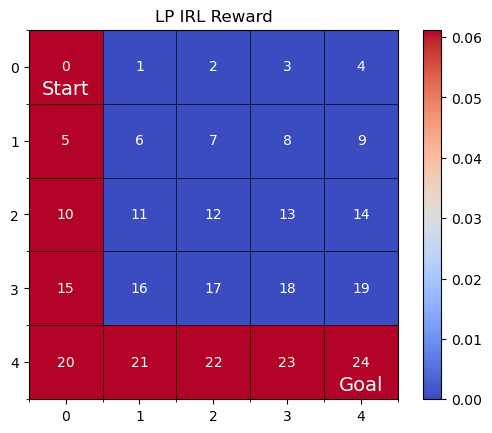

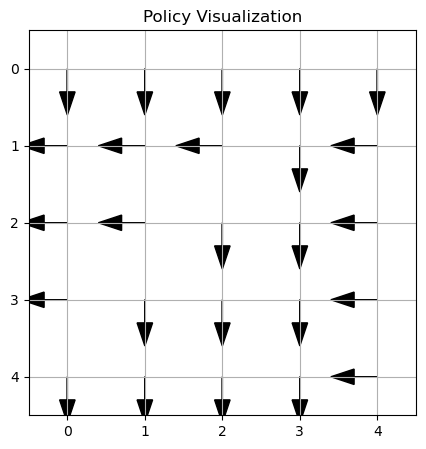

In [8]:
grid_size = 5
start_state = 0
end_state = 24

env = GridWorld(grid_size)

feature_matrix = build_feature_matrix(env.n_states)

# Linear Programming IRL
reward_lp = linear_programming_irl(feature_matrix, s1_traj)
policy_lp = value_iteration(env.transition_matrix, reward_lp)

visualize_Linear(grid_size, start_state, end_state, reward_lp)
visualize_policy(policy_lp, grid_size)

An observable issue with IRL is that when presented with multiple data points that have the same reward values (i.e. multiple optimal policies), the algorithm reveals ambuiguity in selecting and proposing the optimal solution. 

Next we have a case where we add multiple optimal solutions to see the resulting solution

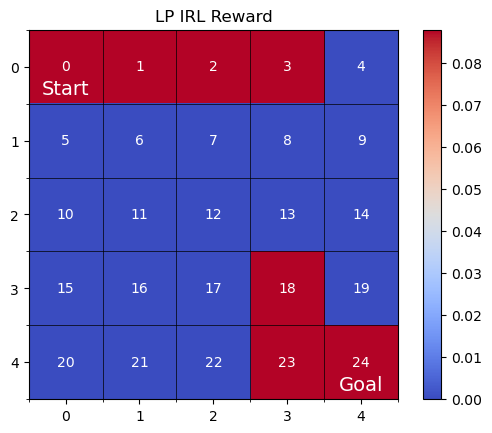

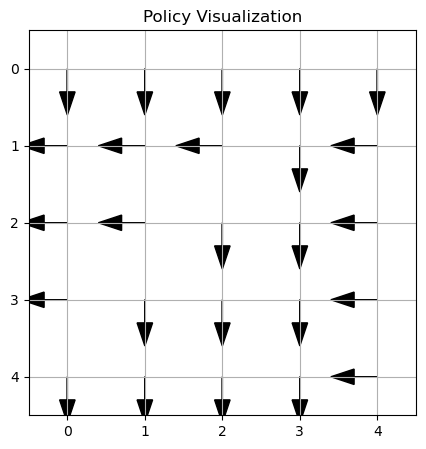

In [9]:
feature_matrix = build_feature_matrix(env.n_states)
reward_lp = linear_programming_irl(feature_matrix, s2_traj)
visualize_Linear(grid_size, start_state, end_state, reward_lp)
visualize_policy(policy_lp, grid_size)

We observe the ambuiguity in selecting the optimal path since multiple states have the same value for reaching middle states before the end goal. In order to solve this problem, the Maximum Entropy IRL was introduced. We follow through with it in the next section.

### Maximum Entropy IRL

One of the reasons to create maximum entropy IRL was to eliminate the ambuiguity of having multiple optimal policies. The authors {cite}`Ziebart2008AAAI` introduce the principle of maximum entropy to resolve the problem. Contrary to linear IRL, the Maxent irl assums a sotchasitc approach to the users policies therefore ranks the policies based on entropy. Here, we estimate Expected State Visitation Frequency (SVF) i.e. how often the agent is expected to visit each state under a policy. This captures how often we expect to visit each state when following a certain policy.

As per {cite}`Ziebart2008AAAI`, trajecotries with equaivalent rewards have equal probablities. and trajecotries with higher rewards are exponentially more preferred. Therefore, 

$P(\omega_i | \theta) = \frac{1}{Z(\theta)}e^{\sum_{s_j \in D}}$

i.e. 
$Z(\theta)$ is the partiution function that converges for fintite problems 

Further, the entropy of the distriubution of the trajectoriues are subjected to reward weights \theta that are used to maximum the likelhood of seeing observed data. This is done using: 

$(\theta^*) = argmax_\theta \sum{log P(\omega|\theta, T)}$

Where, 
$\theta$ = denotes the reward wieghts for given trajectories and observed behaviour 



In [10]:
def state_visitation_frequency(T, policy, start_state, traj_len=15):
    n_states, n_actions, _ = T.shape
    mu = np.zeros((traj_len, n_states))
    mu[0, start_state] = 1
    for t in range(1, traj_len):
        for s in range(n_states):
            for a in range(n_actions):
                next_s = np.argmax(T[s, a])
                mu[t, next_s] += mu[t - 1, s] * policy[s, a]
    return mu.sum(axis=0)

In [11]:
# Maximum Ent IRL 
def maxent_irl(T, feature_matrix, trajectories, start_state, gamma=0.9, l1=0.01, n_iters=100):
    n_states, n_features = feature_matrix.shape
    w = np.random.uniform(size=(n_features,))
    expert_feat_exp = compute_feature_expectations(feature_matrix, trajectories)

    for i in range(n_iters):
        R = feature_matrix.dot(w)
        policy = value_iteration(T, R, gamma)
        D = state_visitation_frequency(T, policy, start_state)
        model_feat_exp = D.dot(feature_matrix)
        grad = expert_feat_exp - model_feat_exp
        w += l1 * grad
    return feature_matrix.dot(w), policy

In [12]:
# Function to Visualize Gird world for Linear IRL
def visualize_maxent(grid_size,start_state, end_state, reward_maxent):
    plt.imshow(reward_maxent.reshape(grid_size, grid_size), cmap='viridis', origin='upper')
    plt.title("MaxEnt IRL Reward")
    plt.xticks(np.arange(grid_size))
    plt.yticks(np.arange(grid_size))
    plt.gca().set_xticks(np.arange(-.5, grid_size, 1), minor=True)
    plt.gca().set_yticks(np.arange(-.5, grid_size, 1), minor=True)
    plt.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

    for i in range(grid_size):
        for j in range(grid_size):
            state = i * grid_size + j
            plt.text(j, i, str(state), ha='center', va='center', color='white')

    start_x, start_y = divmod(start_state, grid_size)
    end_x, end_y = divmod(end_state, grid_size)
    plt.text(start_x,start_y +0.3, "Start", ha='center', va='center', color='white', fontsize=14)
    plt.text(end_x, end_y+0.3, "Goal", ha='center', va='center', color='white', fontsize=14)
    plt.colorbar()
    plt.show()

### Now we Perform Maximum Entropy IRL for the first case 

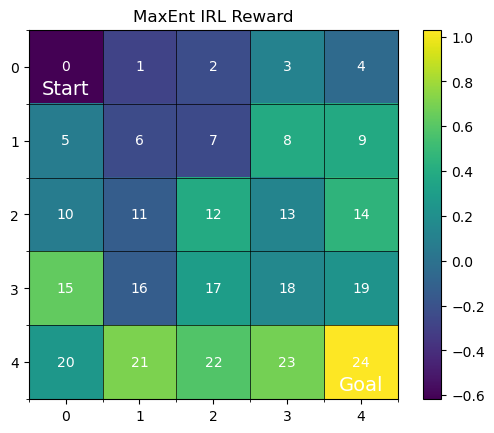

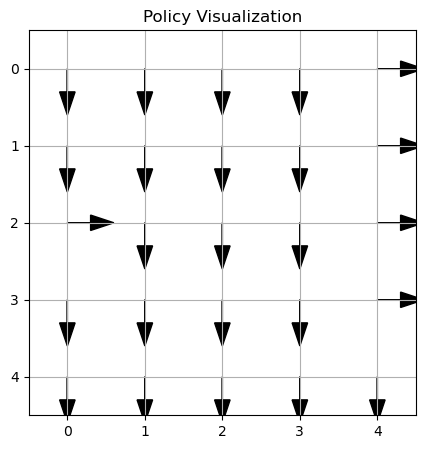

In [13]:
grid_size = 5
start_state = 0
end_state = 24

env = GridWorld(grid_size)

feature_matrix = build_feature_matrix(env.n_states)

# Maximum Entropy IRL IRL
reward_maxent, policy_maxent = maxent_irl(env.transition_matrix, feature_matrix, s1_traj, start_state)

visualize_maxent(grid_size, start_state, end_state, reward_maxent)
visualize_policy(policy_maxent, grid_size)


Here, we observe the tendency of increasing rewards and uniformity of actions as we go closer towards the goal state. The path with the highest cumulative score is the optimal policy i.e. (0->20->24)

Similar the Linear regression, we observe consistent pathways that are highlighted 

Now, we proceed with the second case of multiple optimal trajectories




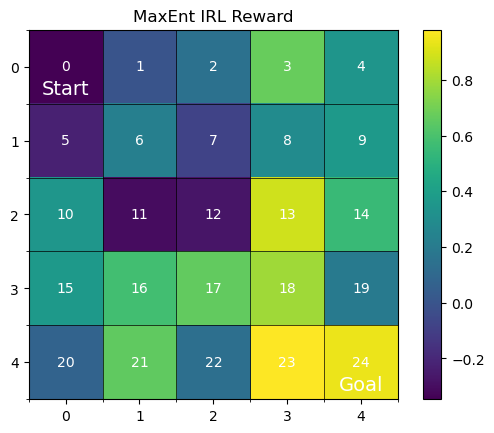

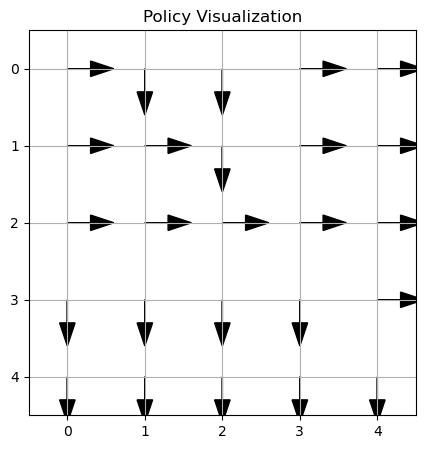

In [14]:
feature_matrix = build_feature_matrix(env.n_states)

# Maximum Entropy IRL IRL
reward_maxent, policy_maxent = maxent_irl(env.transition_matrix, feature_matrix, s2_traj, start_state)

visualize_maxent(grid_size, start_state, end_state, reward_maxent)
visualize_policy(policy_maxent, grid_size)

### Simulating Random Trajectories

Here, we have an example to simulate random trajectories generated to solve the grid world problem. We also have the option to interactively change the start & end points to visualiuze the difference in policy & reward function formation

In [15]:
# This function performs Linear & Maxent IRL along with their Grid world visualizations

def run_irl(grid_size, start_state, end_state, random_traj, n_trajectories):
    env = GridWorld(grid_size)

    expert_traj = []
    for _ in range(n_trajectories):
        if random_traj == 1:
            if np.random.rand() < 0.5: # condition to make sure there are logical solutions included
                traj = env.generate_policy_trajectory(start_state, end_state)
            else:
                traj = env.generate_random_expert_trajectory(start_state, end_state)
        else:
            traj = env.generate_policy_trajectory(start_state, end_state)
        expert_traj.append(traj)
    
    feature_matrix = build_feature_matrix(env.n_states)

    reward_lp = linear_programming_irl(feature_matrix, expert_traj)
    policy_lp = value_iteration(env.transition_matrix, reward_lp)
    reward_maxent, policy_maxent = maxent_irl(env.transition_matrix, feature_matrix, expert_traj, start_state)

    visualize_Linear(grid_size, start_state, end_state,reward_lp)
    visualize_maxent(grid_size, start_state, end_state,reward_maxent)
    
    visualize_policy(policy_lp, grid_size)
    visualize_policy(policy_maxent, grid_size)
    

In the following example, we initialize the grid size, the number of sample trajectories generated, the start and end state. This sample aims to simulate real-world sampled trajecotries and behaviour obtained from experts. 


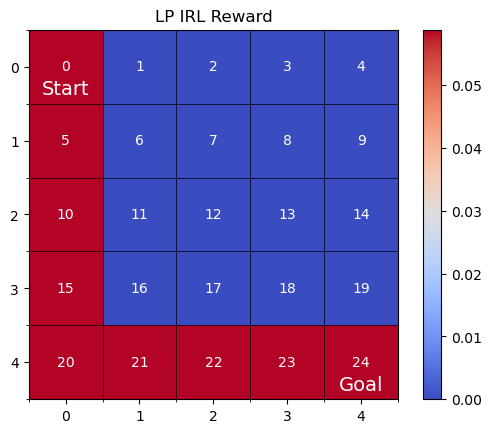

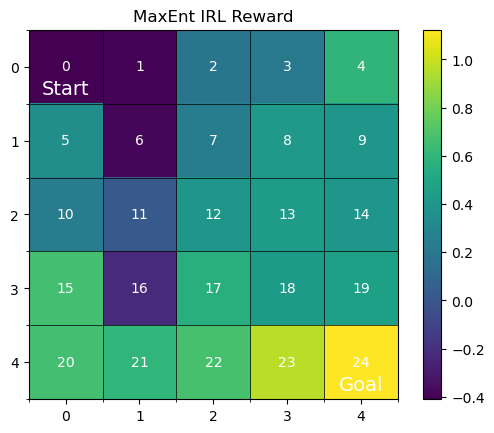

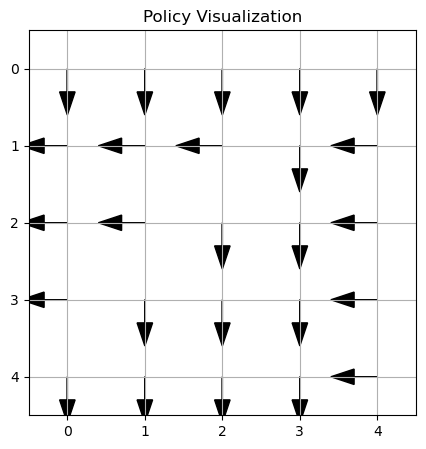

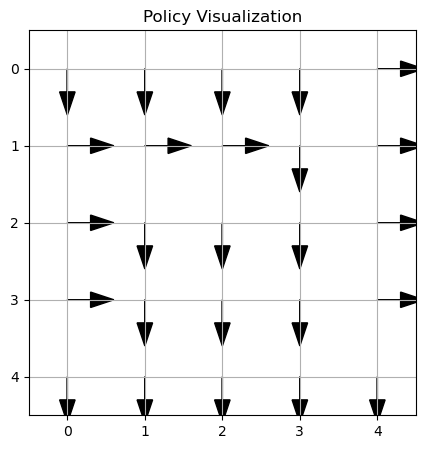

In [16]:
grid_size = 5                                   # Dimension of Grid world
n_trajectories = 20                             # Number of Expert trajecotries to be generated
random_traj = 0                                 # Generate Random Policies = 1, else 0 

start_state = 0                                 # Starting State in the Grid world
end_state = 24                                  # End State in the Grid world

run_irl(grid_size, start_state, end_state, random_traj,n_trajectories)

On testing Linear and Maxent IRL we can observe the difference in approach of reaching the end state via the reward space and the action space. 

- The Linear IRL focuses towards reaching the goal state with the shortest distance possible without discovering all possible routes
- Instances where Linear IRL has multiple optimal solutions, the reward space has no rewards since the state is being reached regardless of making actions


- The MaxEnt IRL on the other hand discoveres the underlying reward function for all possible trajectories since it is based on a stochiastic function. 
- The action space of maximum entropy IRL shows more uniformity than that of linear IRL as it maximizes the actions across state space. 


## Conclusions

Within this chapter, we learn the basics of markov decision prcesses, inverese reinforcement learning and its principle. The Gridworld simulation shows a good example of having entropy as part of decision making for uncertain situations i.e. when we have only historical observation data. We can inversely learn the behaviour using IRL. 

From the grid world examples we see that when faced with trajecotries with multiple optimal scenarios or high variance the Maximum Entropy IRL performs better compared to linear IRL. The inclusion of entropy masssively improves the search for the optimal policy. 